## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import math
import scipy.stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import t
from scipy.stats import f

In [ ]:
def graphs(data):
  data.plot(figsize = (15, 7))
  plt.show()
  sns.displot(data, kind = 'kde')
  plt.show()
  sns.boxplot(data[data.iloc[:,0].name])
  plt.show()

def _get_updown_sub_serias(series):
    subseries = [None, ]
    for i in range(len(series)):
        if i == 1:
            pass
        else:
            if (series[i] - series[i-1]) > 0:
                subseries.append('+')
            else:
                subseries.append('-')
    return subseries

def _get_numeric_updown_criteria(subseries):
    number_subseries = 0
    numeric_subseries = [None, ]
    for i in range(len(subseries)):
        if i == 1:
            pass
        else:
            if subseries[i] != subseries[i-1]:
                number_subseries += 1
                numeric_subseries.append(number_subseries)
            else:
                numeric_subseries.append(number_subseries)
                
    return numeric_subseries
    

def updown_criteria(series):
    subseries = _get_updown_sub_serias(series)
    numeric_subseries = _get_numeric_updown_criteria(subseries)
    sub_df = pd.DataFrame({'series': series, 'subseries': subseries, 'numeric_subs': numeric_subseries})
    val_count_sub_df = sub_df['numeric_subs'].value_counts()
    total_subdf = pd.merge(sub_df, val_count_sub_df, how='left', left_on='numeric_subs', right_index=True)
    
    v_n = total_subdf['numeric_subs_x'].max()
    t_n = total_subdf['numeric_subs_y'].max()
    
    u_t = 1.96
    
    n = total_subdf.shape[0]-1
    
    criteria_x = 1/3 * (2*n-1) - u_t* np.sqrt((16*n-29)/90)
    
    if n <= 26:
        criteria_y = 5
    elif n>26 and n <= 153:
        criteria_y = 6
    elif n>153 and n <= 1170:
        criteria_y = 7
    else:
        criteria_y = 8    
    
    print(f'Число серий v_n = {v_n} больше критического значения равного {criteria_x}: {v_n > criteria_x}')
    print(f'Длина максимальной серии t_n = {t_n} меньше критического значения равного {criteria_y}: {t_n < criteria_y}')
    print('При нарушении хотя бы одного из условий ряд нестационарный')

from scipy.stats import mannwhitneyu
def test_mannwhitneyu(series):
    stat, p = mannwhitneyu(series[:int(len(series)/2)], series[int(len(series)/2):])
    print('stat={0:.3g}, p={0:.3g}'.format(stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')

def _get_ranked(series):
    series_max_index = len(series)
    first_sublist = list(range(2,series_max_index,4))
    first_sublist = sorted(first_sublist + list(range(min(first_sublist)+1, max(first_sublist)+2, 4)))
    second_sublist = [col for col in list(range(1,series_max_index+1)) if col not in first_sublist]
    first_sublist.reverse()
    return second_sublist + first_sublist  

def siegel_tukey(series):
    first_subsample, second_subsample = series[:int(len(series)/2)], series[int(len(series)/2):]
    first_subsample, second_subsample = pd.DataFrame({'values': first_subsample}), pd.DataFrame({'values': second_subsample})
    first_subsample['class'] = 'first'
    second_subsample['class'] = 'second'
    final_df = pd.concat([first_subsample,second_subsample]).sort_values(by='values')
    
    final_df['ranked'] = _get_ranked(final_df['values'])
    _ = pd.pivot_table(final_df, index='class', aggfunc=['sum'])['sum']['ranked']
    mean_w = _['first']-len(first_subsample)*(len(first_subsample)+len(second_subsample)+1)/2 
    disp_w = len(first_subsample)*len(second_subsample)*(len(first_subsample)+len(second_subsample)+1)/12
    if disp_w != 0:
        z_value = mean_w/np.sqrt(disp_w)
    else:
        print(f'disp_w = 0')
        
    if z_value < 0:
        z_value = (mean_w + 0.5) / np.sqrt(disp_w)
    else:
        z_value = (mean_w - 0.5) / np.sqrt(disp_w)
    print(f'z value: {z_value:.3f}')
    if z_value < 1.97 and z_value > -1.97:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')

def outliers(data, i): 
  data = data.sort_values(by = data.iloc[:,0].name)
  data.iloc[:,0][0:i] = data.iloc[:,0][i]
  data.iloc[:,0][(len(data)-i):len(data)] = data.iloc[:,0][len(data) - i]
  data = data.sort_index()
  return(data)

def t_f_criterion(data):
  X = data.values
  split = round(len(X) / 2)
  X1, X2 = X[0:split], X[split:]
  mean1, mean2 = X1.mean(), X2.mean()
  var1, var2 = X1.var(), X2.var()
  print('Тестирование средних. Статистика Стьюдента: {}. Критическое значение: {}'.format(((mean1-mean2)/math.sqrt(var1+var2)), t.ppf(0.95, len(X1)-1)))
  print('Тестирование дисперсий. Статистика Фишера: {}. Критическое значение: {}'.format(var2/var1, f.ppf(0.95, len(X1)-1, len(X2)-1)))

import statistics
def median_criterion (data):
  result = []
  for i in range(len(data)):
    if data[i] < statistics.median(data):
      result.append('-')
    elif data[i] == statistics.median(data): result.append(' ')
    else: result.append('+')
  vt = 1
  tmax = 1
  t = 1
  for i in range(1, len(result)):
    if result[i] == result[i-1]: 
      vt = vt
      t += 1
      if t > tmax: tmax = t
    else:  
      vt +=1
      t = 0
  print('Число серий = {} больше рассчитанного {}: {}'.format(vt, (0.5*(len(data) + 2) - 1.96*math.sqrt(len(data)-1)), vt > (0.5*(len(data) + 2) - 1.96*math.sqrt(len(data)-1))))
  print('Максимальная длина серии = {} меньше рассчитанного {}: {}'.format(tmax, (1.43 * math.log(len(data + 1))), tmax < (1.43 * math.log(len(data + 1)))))
  print('При нарушении хоть одного условия, ряд не стационарный')

import statistics
def abbe_criterion (data):
  result = []
  sumy = [data[0]-np.average(data)]
  for i in range(1, len(data)):
    result.append((data[i]-math.pow(data[i-1], 2)))
    sumy.append(data[i]-np.average(data))
  g2T = 1 / (2 * (len(data) - 1)) * sum(result)
  sigma2 = 1 / (len(data) - 1) * sum(sumy)
  yt = g2T / sigma2
  u = scipy.stats.norm.ppf(0.05)
  print('Рабочая статистика Аббе = {} меньше либо равна рассчитанного ymin0,05(T) = {}: {}'.format(yt, 1 + u / math.sqrt(len(data) + 0.5 * (1 + math.pow(u, 2))), yt <= 1 + u / math.sqrt(len(data) + 0.5 * (1 + math.pow(u, 2)))))

from statsmodels.tsa.stattools import adfuller
def dicky_fuller(series):
  X = series.values
  result = adfuller(X)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
  print('p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
  print('p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')

from scipy.stats import kurtosis, skew
def kurt_skew(data):
  print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(data) ))
  print( 'skewness of normal distribution (should be 0): {}'.format( skew(data) ))

def make_autocorr_plot(series, lags=24):
    background_color = '#f6f5f5'
    plt.rcParams['figure.dpi'] = 600
    fig = plt.figure(figsize=(12, 10), facecolor=background_color)
    gs = fig.add_gridspec(2, 1)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0])

    ax0.set_facecolor(background_color)
    ax1.set_facecolor(background_color)
    
    
    background_color = '#f6f5f5'
    ax0.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
    ax0.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
    ax0.axes.xaxis.set_visible(False)
    ax1.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
    ax1.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
    
    plot_acf(series, lags=lags, zero=False, ax=ax0);
    plot_pacf(series, lags=lags, zero=False, ax=ax1);



In [ ]:
def IsStationary (data):
  print('='*10)
  dicky_fuller(data)
  print('='*10)
  kurt_skew(data)
  if (np.abs(kurtosis(data))<=0.05 and np.abs(skew(data)) <= 0.05):
    print('='*10)
    t_f_criterion(data)
    print('='*10)
    median_criterion(data)
    print('='*10)
    abbe_criterion(data)
    print('='*10)
  else:
    print('='*10)
    print('Тест Сиджела-Тьюки')
    siegel_tukey(data)
    print('='*10)
    print('Тест Манна-Уитни')
    test_mannwhitneyu(data)
    print('='*10)

In [ ]:
def fillnan(data):
  RowName = data.iloc[:,0].name
  count = 0
  for i in range(0, len(data)-1):
    if np.isnan(data[RowName][i]):
      j = i
      while np.isnan(data[RowName][j]): 
        j+=1
        count +=1
      if (count == 1): data[RowName][i] = data[RowName][i-1]
      if (count == 2): 
        data[RowName][i] = data[RowName][i-1]
        data[RowName][i+1] = data[RowName][i+2]
      if (count == 3):
        data[RowName][i] = data[RowName][i-1]
        data[RowName][i+1] = data[RowName][i-1]
        data[RowName][i+2] = data[RowName][i+3]
      if (count == 4):
        data[RowName][i] = data[RowName][i-1]
        data[RowName][i+1] = data[RowName][i-1]
        data[RowName][i+2] = data[RowName][i+4]
        data[RowName][i+3] = data[RowName][i+4]
      if (count >= 5):
        for k in range(0, count):
          data[RowName][i+k] = data[RowName][i + count + 1]
    count = 0
  return data

In [ ]:
def Smirnov_Grabbs(data, m):
  RowName = data.iloc[:,0].name
  mean = data[RowName].mean()
  n = data[RowName].shape[0]
  s = np.std(data[RowName].to_numpy()) * (n **(0.5)) *(1/(n-1)) 
  max = data[RowName][m]
  T = (max - mean)/ s
  print('T = ', T)

  a10 = 2.987 #for n => 50
  a5 = 3.3160
  a2_5 = 3.320
  if T <= a10:
    print(max, ' - наблюдение не нарушает однородность ')
  elif T > a2_5:
    print(max, ' - наблюдение грубо нарушает однородность, нетипичное наблюдение ')
  elif (T <= a2_5) & (T > a10) : 
    print(max, 'требуюстся доп аргументы')

def L_Titien_Mur(data, n):
  RowName = data.iloc[:,0].name
  n1 = data[RowName].shape[0]
  mean = data[RowName].mean()
  s = np.std(data[RowName].to_numpy()) * (n1 **(0.5)) *(1/(n1-1)) 
  d1 = s*s
  max = data[RowName][n]
  df_g = data.loc[data[RowName] != max]
  n2 = df_g[RowName].shape[0]
  mean1 = df_g[RowName].mean
  s2 = np.std(df_g[RowName].to_numpy()) * (n2 **(0.5)) *(1/(n2-1)) 
  d2= s2*s2
  L = d2/d1
  print('L = ', L)

  a10 = 0.479 #for n => 50
  a5 = 0.452
  a2_5 = 0.428
  if L >= a10:
    print(max, ' - наблюдение не нарушает однородность ')
  elif L < a2_5:
    print(max, ' - наблюдение грубо нарушает однородность, нетипичное наблюдение ')
  elif (L >= a2_5) & (L < a10) : 
    print(max, 'требуюстся доп аргументы')

def E_Titien_Mur(data, n):
  RowName = data.iloc[:,0].name
  df_func = data
  k = 1 #кол во ошибок ввод
  n1 = df_func[RowName].shape[0]
  mean = df_func[RowName].mean()
  df_func['r'] = abs(df_func[RowName]-mean)
  df_func['z'] = df_func['r'].sort_values()
  max_z = df_func['z'][n]

  df_g = df_func.loc[df_func['z'] != max_z]
  s = np.std(df_func['z'].to_numpy()) * (n1 **(0.5)) *(1/(n1-1)) 
  d1 = s*s
  n2 = df_g['z'].shape[0]
  s2 = np.std(df_g['z'].to_numpy()) * (n2 **(0.5)) *(1/(n2-1)) 
  d2= s2*s2
  Е = d2/d1
  print('Е = ', Е)

  a10 = 0.286 #for n => 50
  a5 = 0.267
  a2_5 = 0.25
  if Е >= a10:
    print(df_func[RowName].loc[ df_func['z'] == max_z].values, ' - наблюдение не нарушает однородность ')
  elif Е < a2_5:
    print(df_func[RowName].loc[ df_func['z'] == max_z].values, ' - наблюдение грубо нарушает однородность, нетипичное наблюдение ')
  elif (Е >= a2_5) & (Е < a10) : 
    print(df_func[RowName].loc[ df_func['z'] == max_z].values, 'требуюстся доп аргументы')

# Первый датасет

10-Year Breakeven Inflation Rate, Percent, Daily, Not Seasonally Adjusted

In [ ]:
df1 = pd.read_excel('./dataset_1.xlsx')
df1['observation_date'] = pd.to_datetime(df1['observation_date'])
df1 = df1.set_index('observation_date')
df1 = df1.asfreq('D')
df1 = df1[len(df1)-701:len(df1)-1]

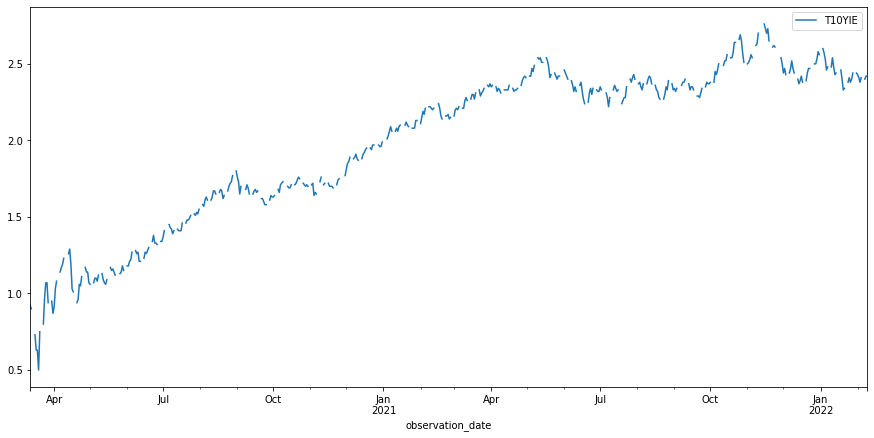

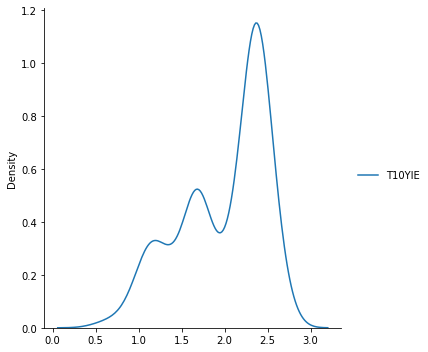

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


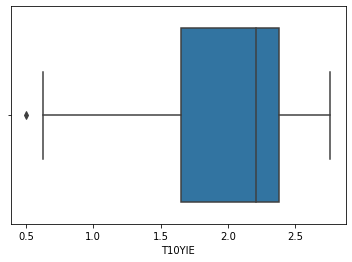

In [ ]:
graphs(df1)

In [ ]:
df1.head()

,T10YIE
observation_date,
2020-03-12,0.92
2020-03-13,0.90
2020-03-14,NaN
2020-03-15,NaN
2020-03-16,0.73


In [ ]:
print('Количество пропусков = {}'.format(df1.isna().sum()))
print('Количество пропусков составляет {} процент от объема всей выборки'.format(df1.isna().sum()/len(df1)*100))

Количество пропусков = T10YIE    219
dtype: int64
Количество пропусков составляет T10YIE    31.285714
dtype: float64 процент от объема всей выборки


Так как пропуски составляют большой процент всех данных, мы не можем строить оперативный прогноз. Заполнение пропусков приведет к образованию распределения отличного от изначального, а соответственно прогноз не будет точным. Построим краткосрочный прогноз на недельном агрегате

### Краткосрочный прогноз

In [ ]:
df1 = pd.read_excel('./dataset_1.xlsx')
df1['observation_date'] = pd.to_datetime(df1['observation_date'])
df1 = df1.resample('W',  on='observation_date').mean().ffill()

In [ ]:
df1.head(5)

,T10YIE
observation_date,
2017-02-12,2.010000
2017-02-19,2.021429
2017-02-26,2.026000
2017-03-05,2.022857
2017-03-12,2.012000


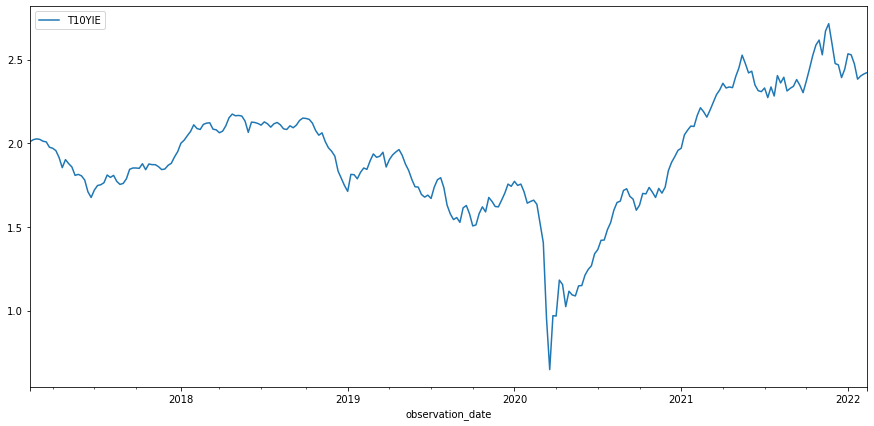

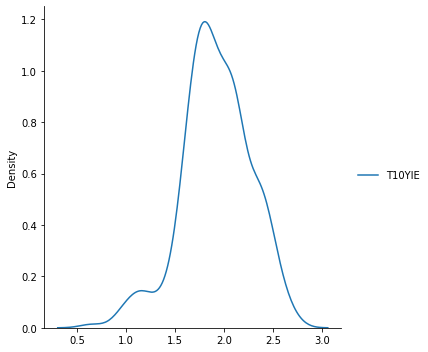

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


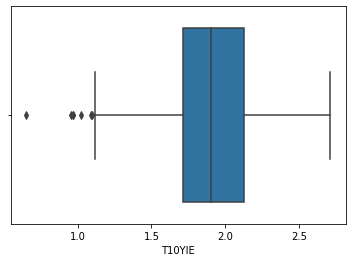

In [ ]:
graphs(df1)

Ряд не стационарный. Распределение ряда близко к унимодальному. Из диаграммы размаха видно, что пристуствуют некоторых выбросы.

In [ ]:
df1.to_excel("weekly_T10YIE.xlsx")

In [ ]:
#проверим, являются ли значения выбросами
L_Titien_Mur(df1, 162)
Smirnov_Grabbs(df1, 162)
Smirnov_Grabbs(df1, 249)
Smirnov_Grabbs(df1, 222)
Smirnov_Grabbs(df1, 248)

L =  0.9565511465305533
0.648  - наблюдение не нарушает однородность 
T =  -58.69364085980578
0.648  - наблюдение не нарушает однородность 
T =  36.731218524701895
2.714  - наблюдение грубо нарушает однородность, нетипичное наблюдение 
T =  28.04783345002258
2.526  - наблюдение грубо нарушает однородность, нетипичное наблюдение 
T =  34.69893691147907
2.67  - наблюдение грубо нарушает однородность, нетипичное наблюдение 


In [ ]:
df1 = outliers(df1, 5) #избавимся от выбросов, не изменяя объем выборки

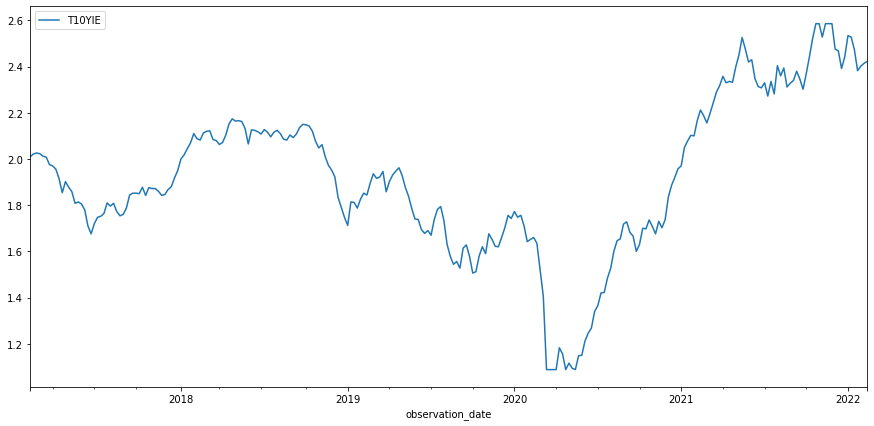

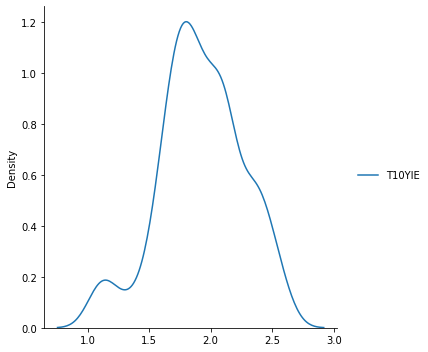

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


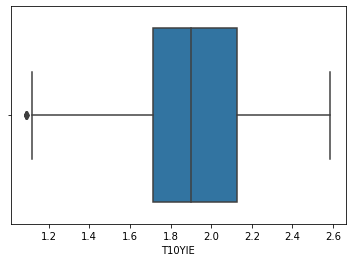

In [ ]:
graphs(df1)

По графикам можно заметить, что выбросы были убраны, однако распределение все равно не полностью унимодальное. Рассмотрим автокорреляционную функцию.

<Figure size 504x288 with 0 Axes>

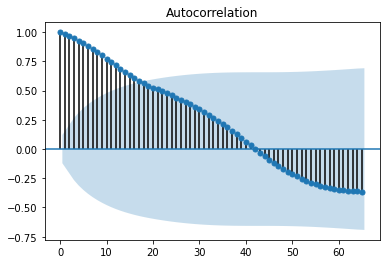

In [ ]:
plt.figure(figsize = (7,4))
plot_acf(df1['T10YIE'], lags = 65)
plt.show()

Значения переходят в отрицательную плоскость, возможно ряд характеризуется случайным блужданием. Также АКФ быстро затухает

In [ ]:
IsStationary(df1['T10YIE'])

ADF Statistic: -1.560295
p-value: 0.503502
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573
p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
excess kurtosis of normal distribution (should be 0): -0.02315484838815207
skewness of normal distribution (should be 0): -0.27203149193668885
Тест Сиджела-Тьюки
z value: 11.999
Probably different distributions
Тест Манна-Уитни
stat=7.96e+03, p=7.96e+03
Probably the same distribution


Проверка на стационарность показала, что ряд не является стационарным

Так как рассматривается агрегат данных, построим для прогноза авторегрессионную модель и сплайн.

## Сплайн

Построим квадратичный сплайн со следующими факторами: t, d1, d2, d2*t, t^2. коэффициент при d1*t оказался не значим

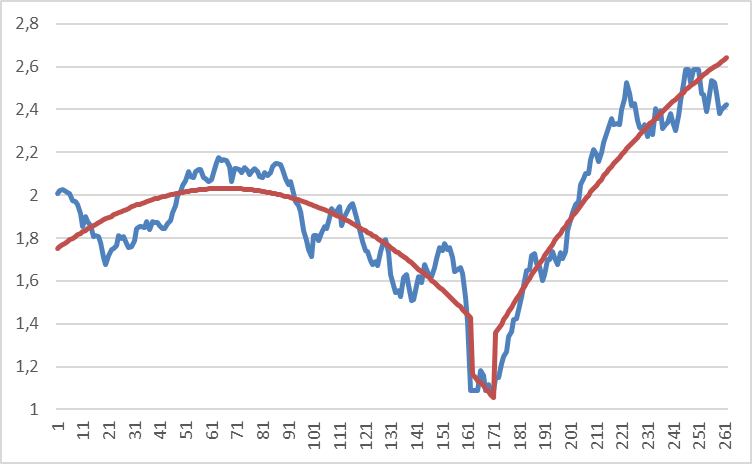

![image.png](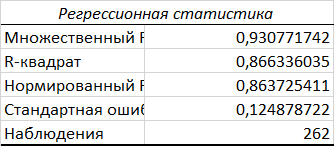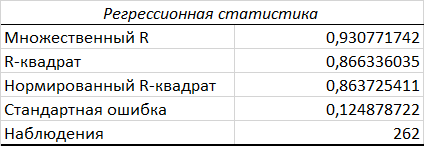)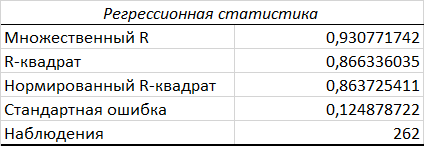

Все коэффициенты значимы

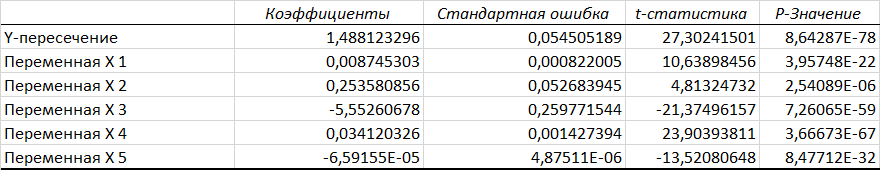

## AR

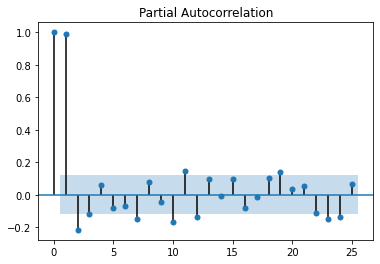

In [ ]:
plot_pacf(df1['T10YIE'])
plt.show()

Так как первый коэффициент значим, построим модель AR(1)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
arima_model = ARIMA(df1['T10YIE'], order=(1,0,0))
model = arima_model.fit()
print(model.summary())
print(model.aic)

                              ARMA Model Results                              
Dep. Variable:                 T10YIE   No. Observations:                  262
Model:                     ARMA(1, 0)   Log Likelihood                 428.598
Method:                       css-mle   S.D. of innovations              0.047
Date:                Tue, 14 Jun 2022   AIC                           -851.196
Time:                        20:27:27   BIC                           -840.491
Sample:                    02-12-2017   HQIC                          -846.894
                         - 02-13-2022                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.0506      0.230      8.901      0.000       1.599       2.502
ar.L1.T10YIE     0.9903      0.007    139.271      0.000       0.976       1.004
                                    Roots   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


Все коэффициенты значимы, однако остатки не являются белым шумом. Также коэффициент не соответствует ограничениям, если брать в учет стандтартное отклонение. Среднеквадратичное отклонение равняется модели 0,0469374, что больше, чем у сплайн-модели

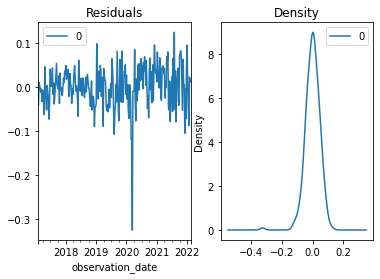

In [ ]:
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

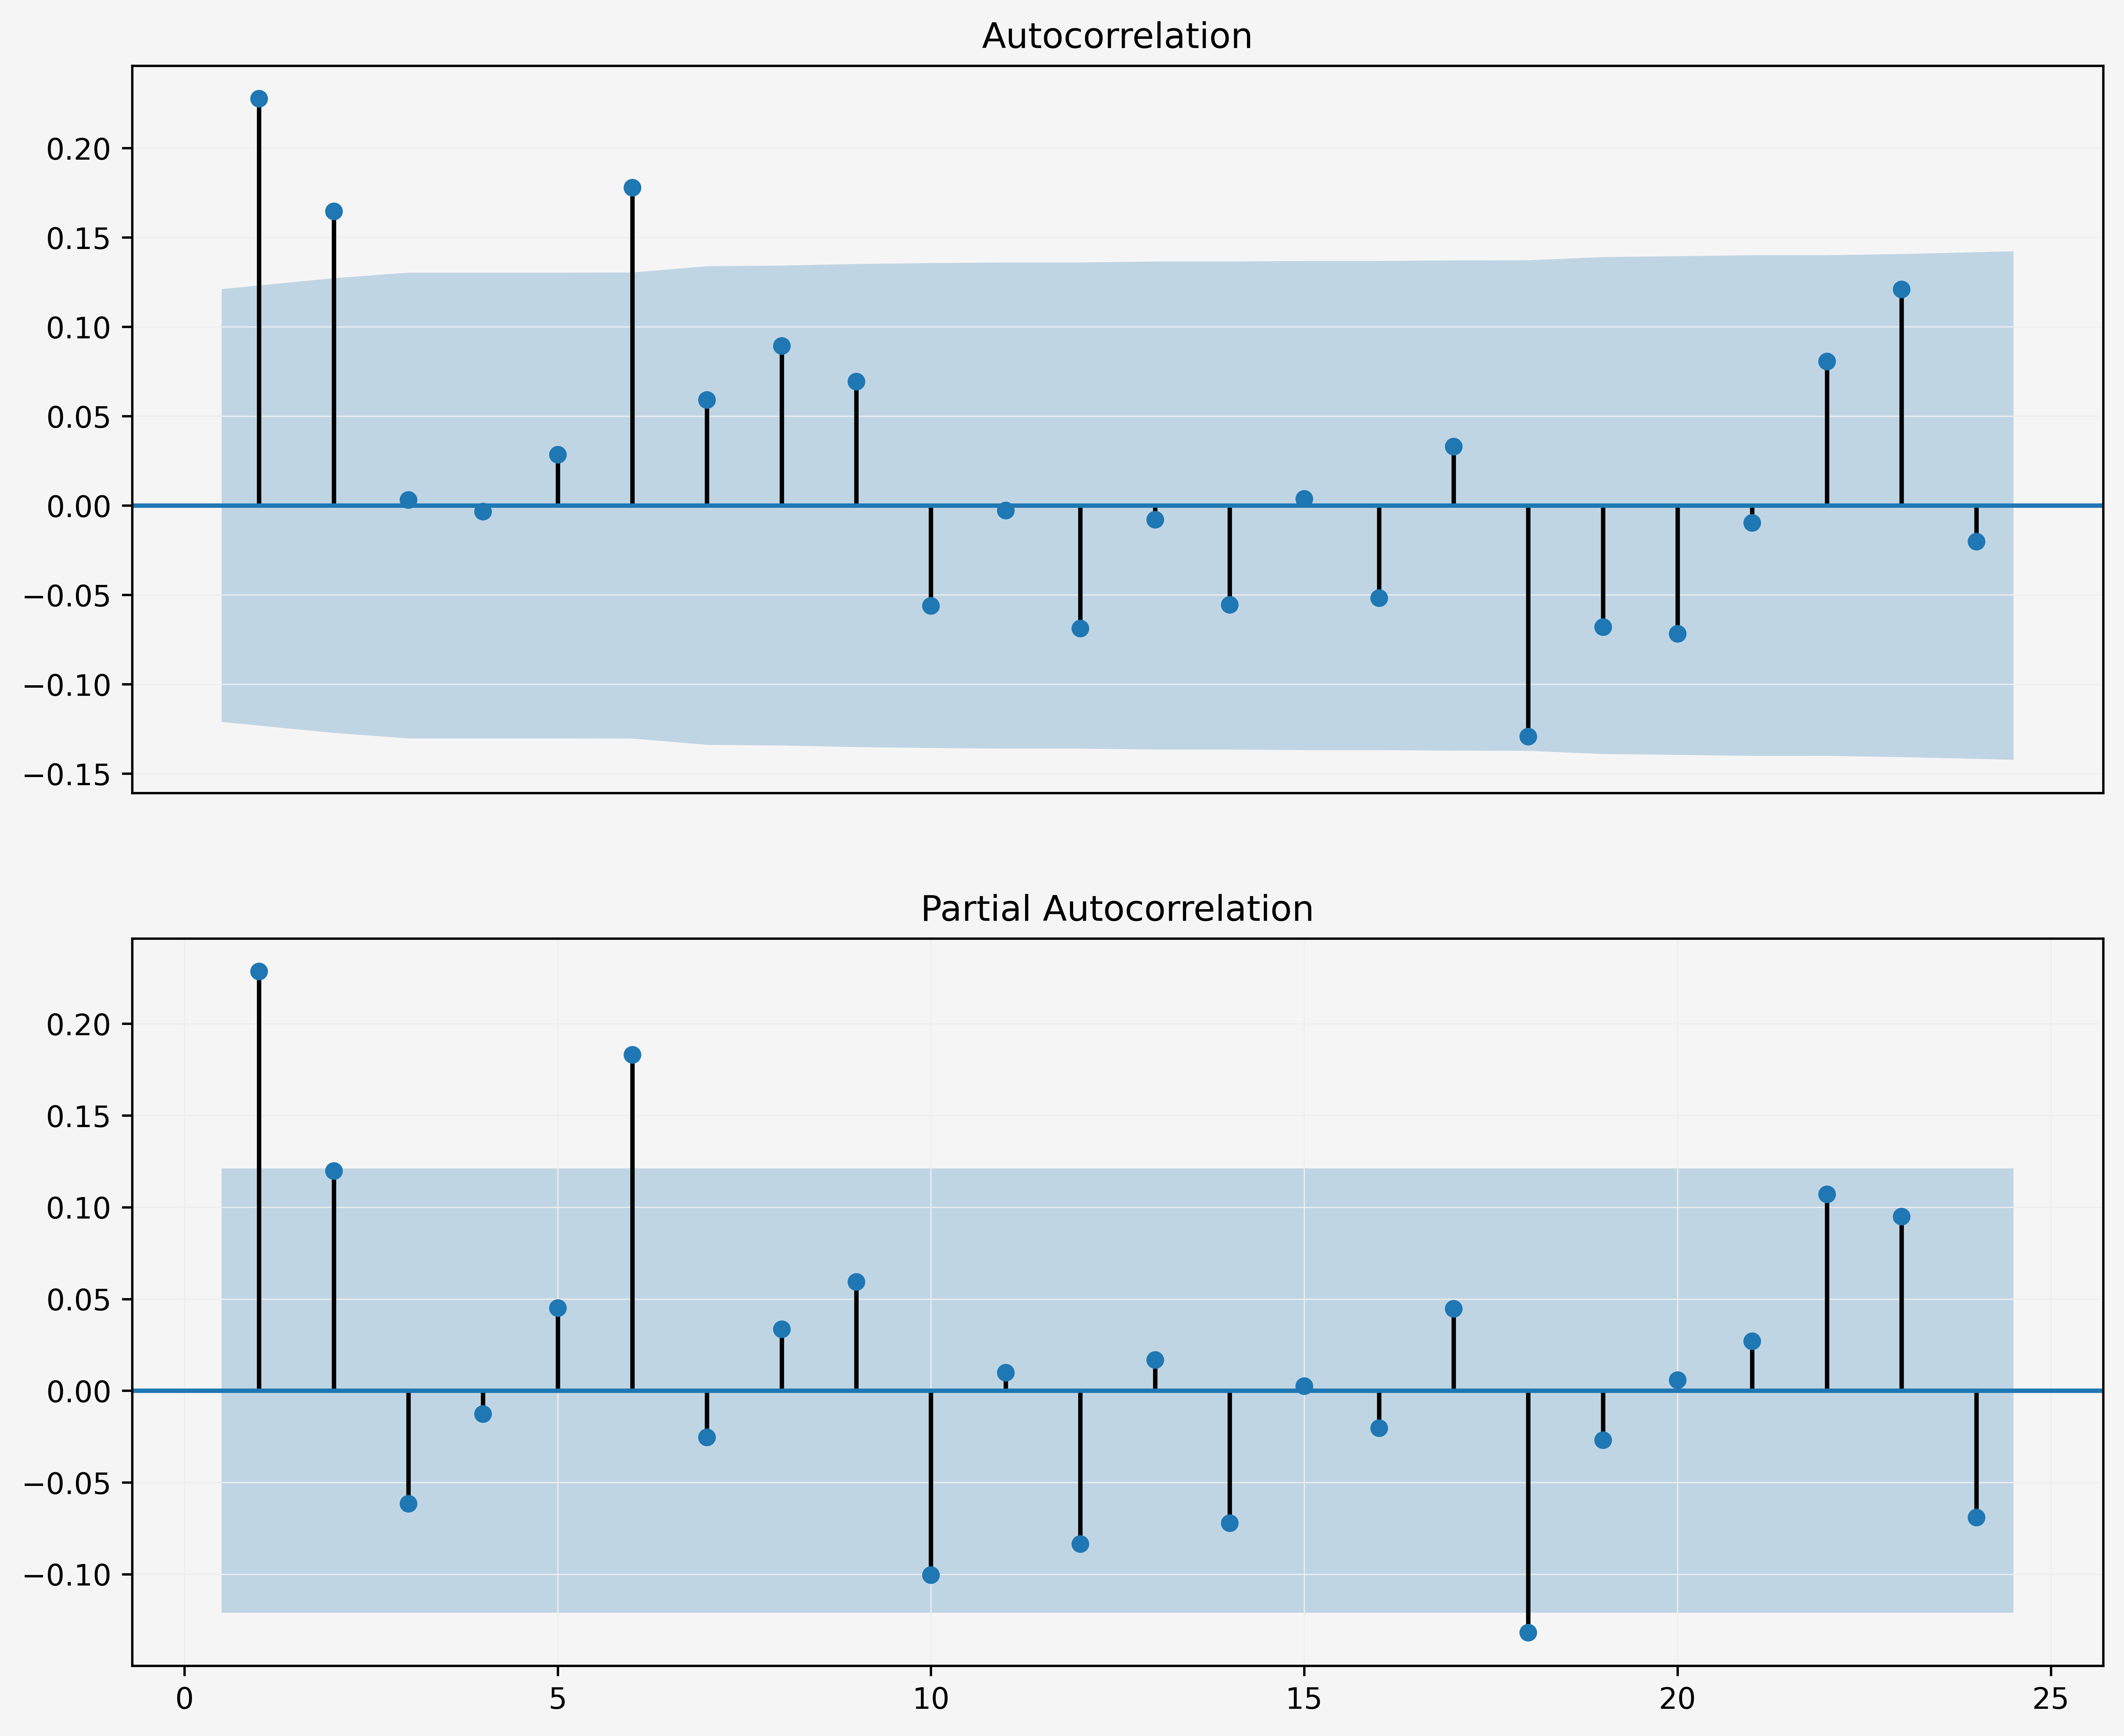

In [ ]:
make_autocorr_plot(residuals)

Построим модель AR(2)

In [ ]:
arima_model = ARIMA(df1['T10YIE'], order=(2,0,0))
model = arima_model.fit()
print(model.summary())
print(model.aic)

                              ARMA Model Results                              
Dep. Variable:                 T10YIE   No. Observations:                  262
Model:                     ARMA(2, 0)   Log Likelihood                 435.561
Method:                       css-mle   S.D. of innovations              0.046
Date:                Tue, 14 Jun 2022   AIC                           -863.122
Time:                        20:29:42   BIC                           -848.848
Sample:                    02-12-2017   HQIC                          -857.385
                         - 02-13-2022                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.0189      0.201     10.037      0.000       1.625       2.413
ar.L1.T10YIE     1.2157      0.060     20.277      0.000       1.098       1.333
ar.L2.T10YIE    -0.2274      0.060     -3.78

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


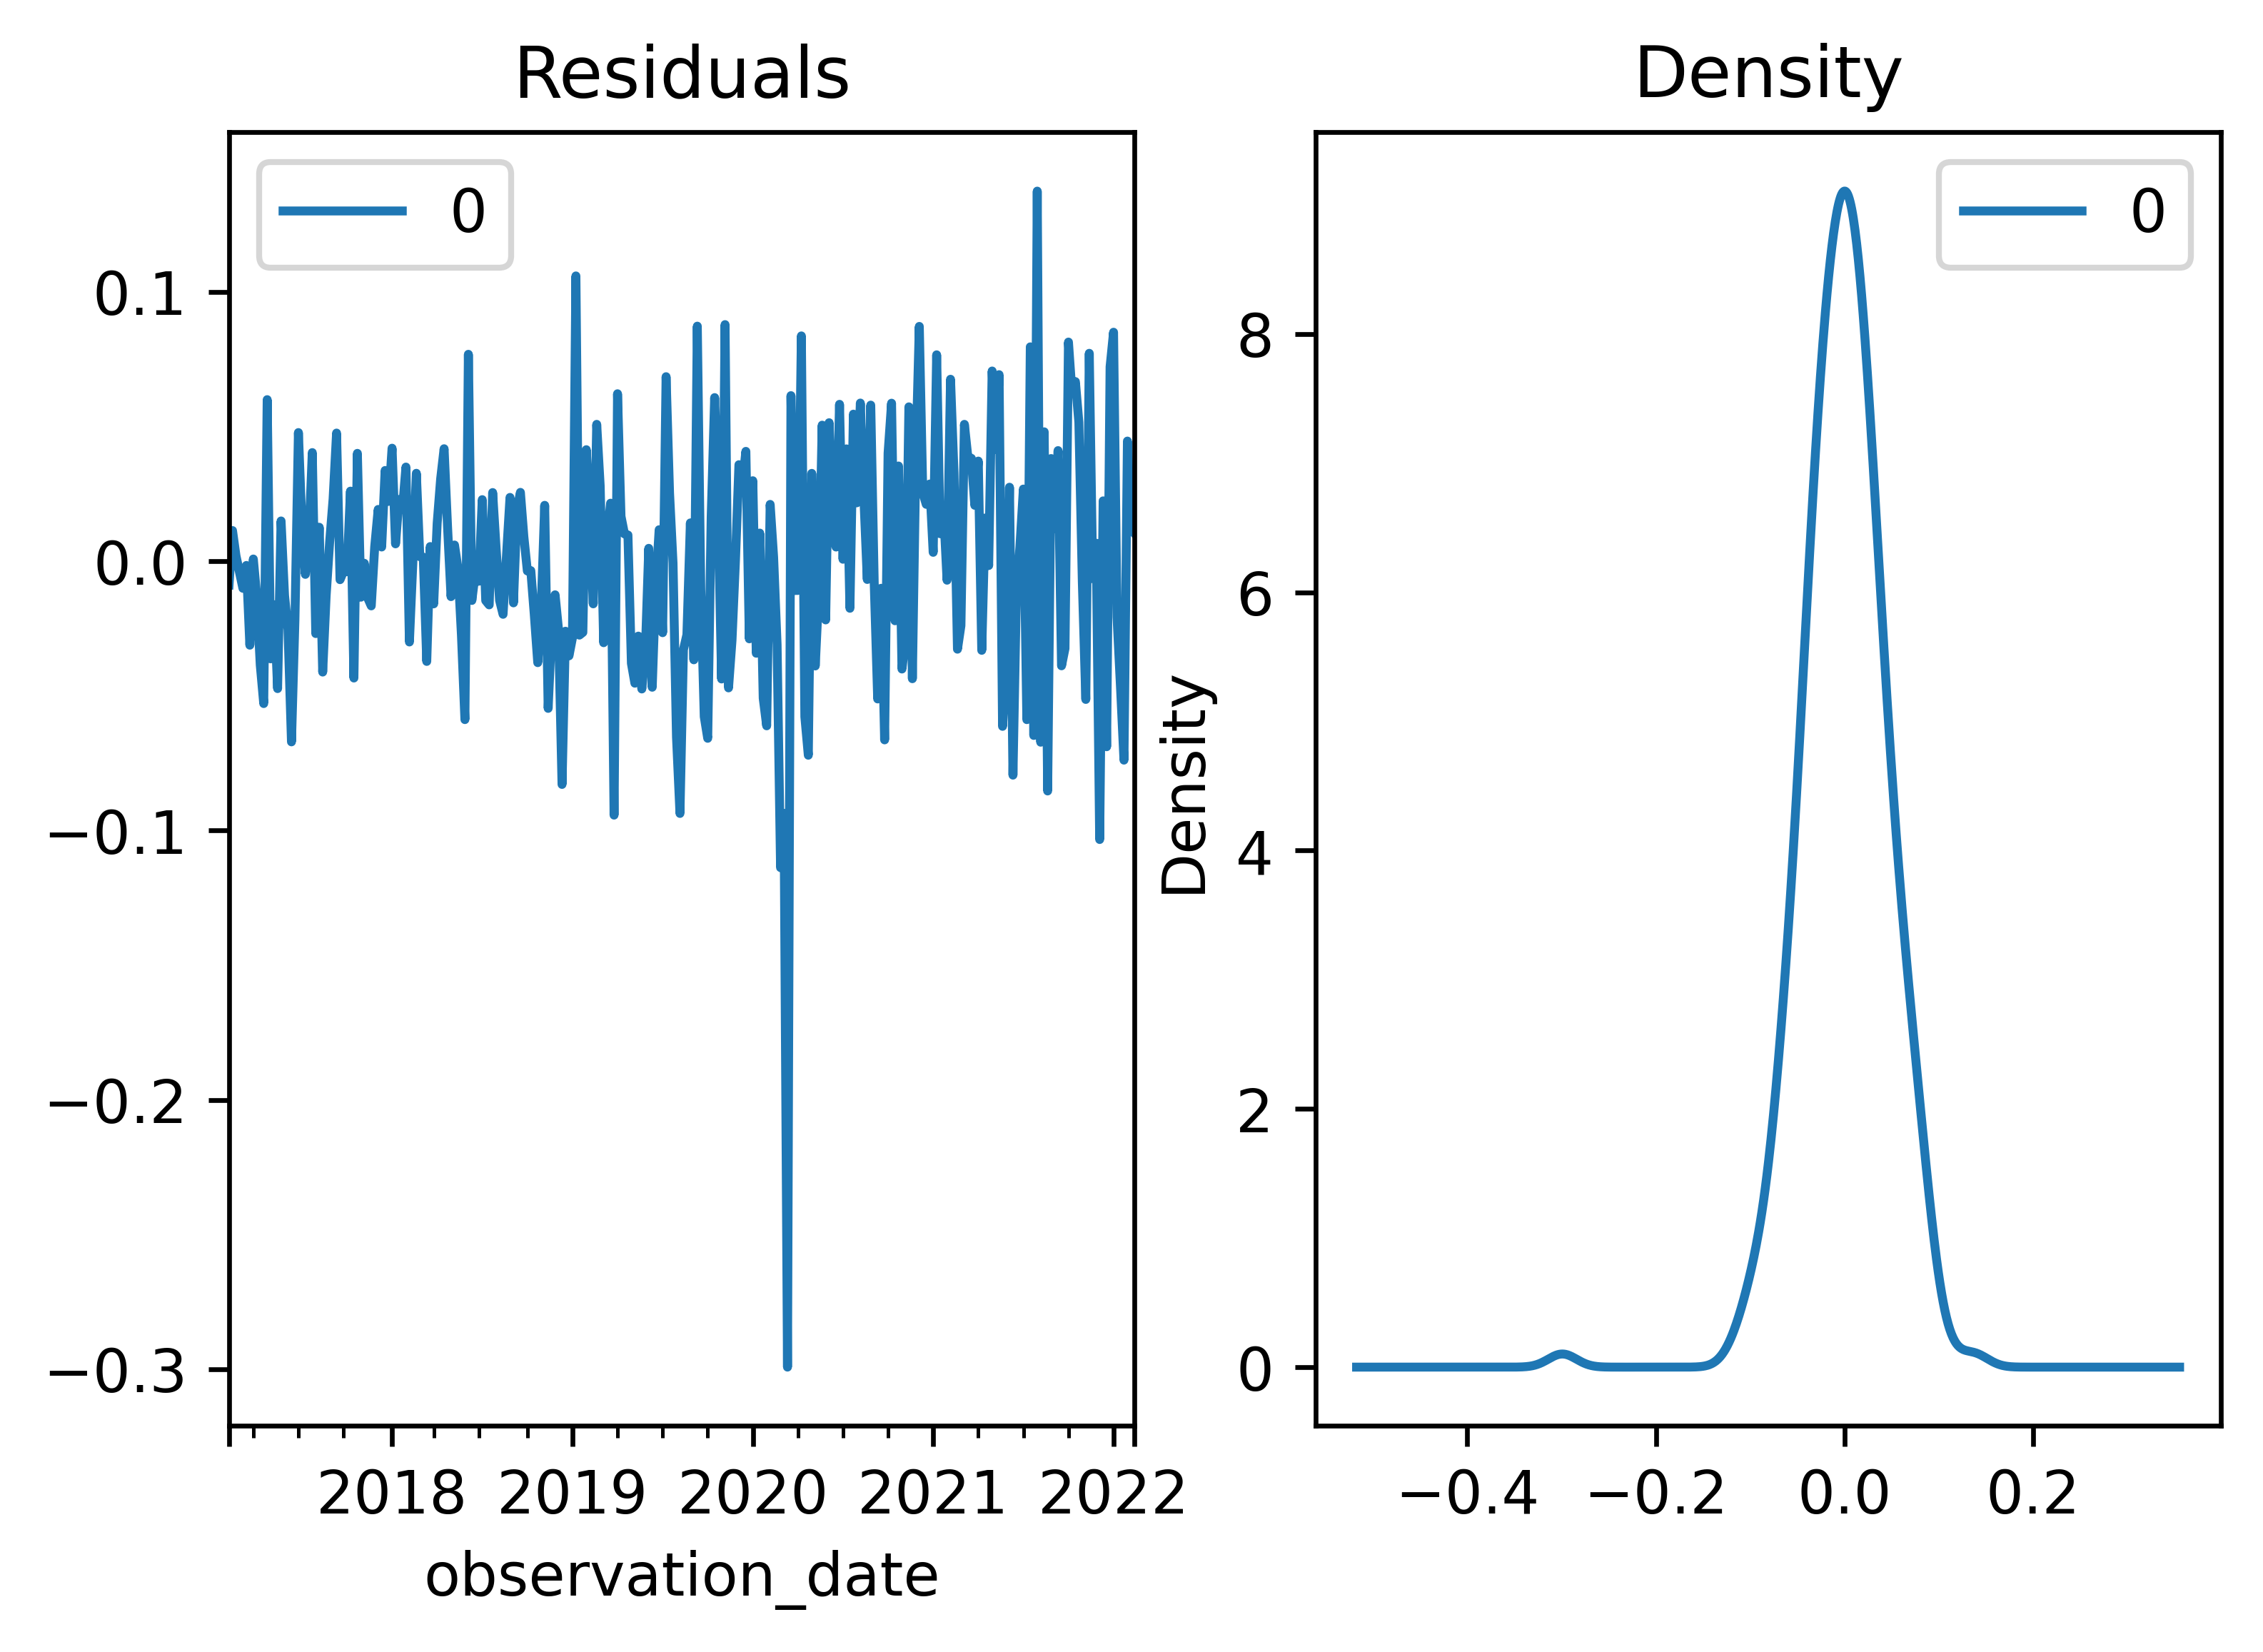

In [ ]:
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Все коэффициенты значимы, однако они удовлетворяют не всем ограничениям

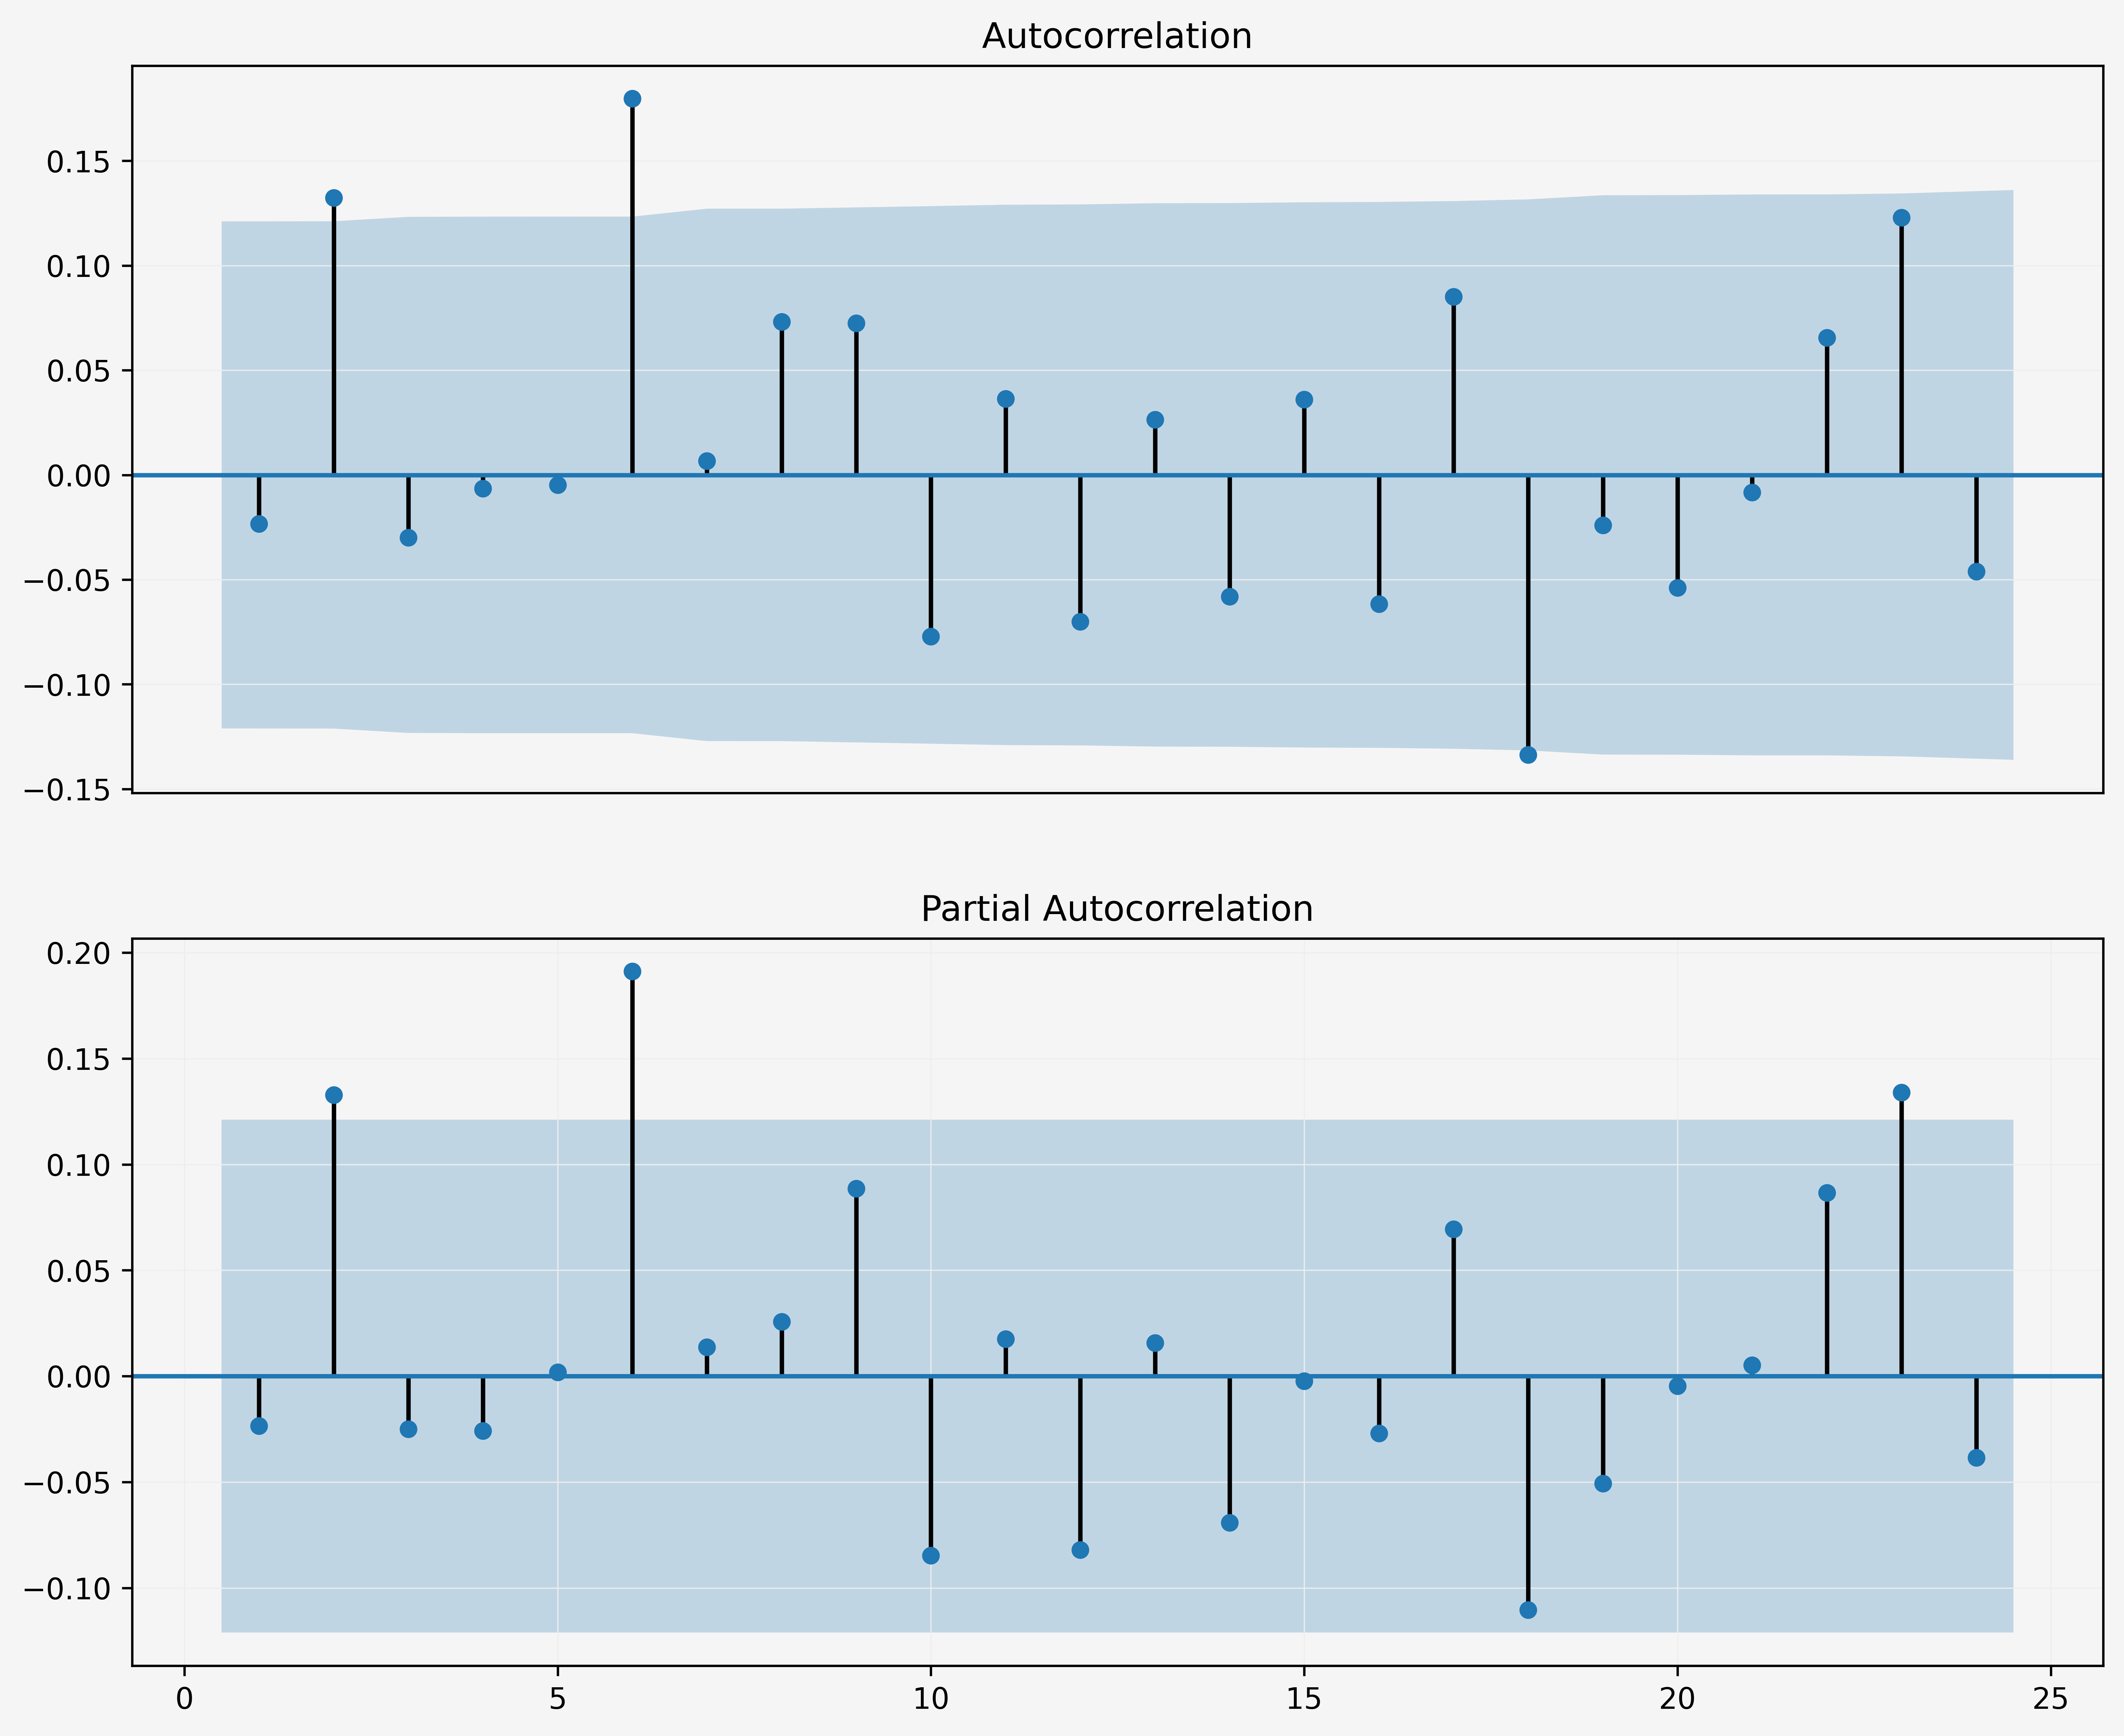

In [ ]:
make_autocorr_plot(residuals)

Имеются несколько значимых столбов в АКФ и ЧАКФ остатков. Тест Льюнга-Бокса показывает, что остатки не являются случайными, необходимо дополнительно их моделировать. При этом среднеквадратичное отклонение равняется 0,0459117, соответственно это лучшая модель из всех рассмотренных

Построим модель ARCH(0,1,1)

In [ ]:
pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 902 kB 6.6 MB/s 
     |████████████████████████████████| 9.8 MB 34.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from arch import arch_model

In [ ]:
am = arch_model(df1['T10YIE'], mean='zero', p=0, o=1, q=1, power=1.0, dist='StudentsT')
res = am.fit(update_freq=5, last_obs="2022-02-13")
print(res.summary())

Iteration:      5,   Func. Count:     33,   Neg. LLF: 551.9269544728807
Iteration:     10,   Func. Count:     63,   Neg. LLF: 546.4480792383963
Iteration:     15,   Func. Count:     93,   Neg. LLF: 545.0139916882871
Iteration:     20,   Func. Count:    127,   Neg. LLF: 544.9008476720153
Iteration:     25,   Func. Count:    157,   Neg. LLF: 544.693551119406
Iteration:     30,   Func. Count:    187,   Neg. LLF: 544.6928586846209
Iteration:     35,   Func. Count:    222,   Neg. LLF: 544.6920815193685
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 544.692081521817
            Iterations: 35
            Function evaluations: 233
            Gradient evaluations: 35
                       Zero Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                       T10YIE   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      

Коэффициенты значимы

Графики модели

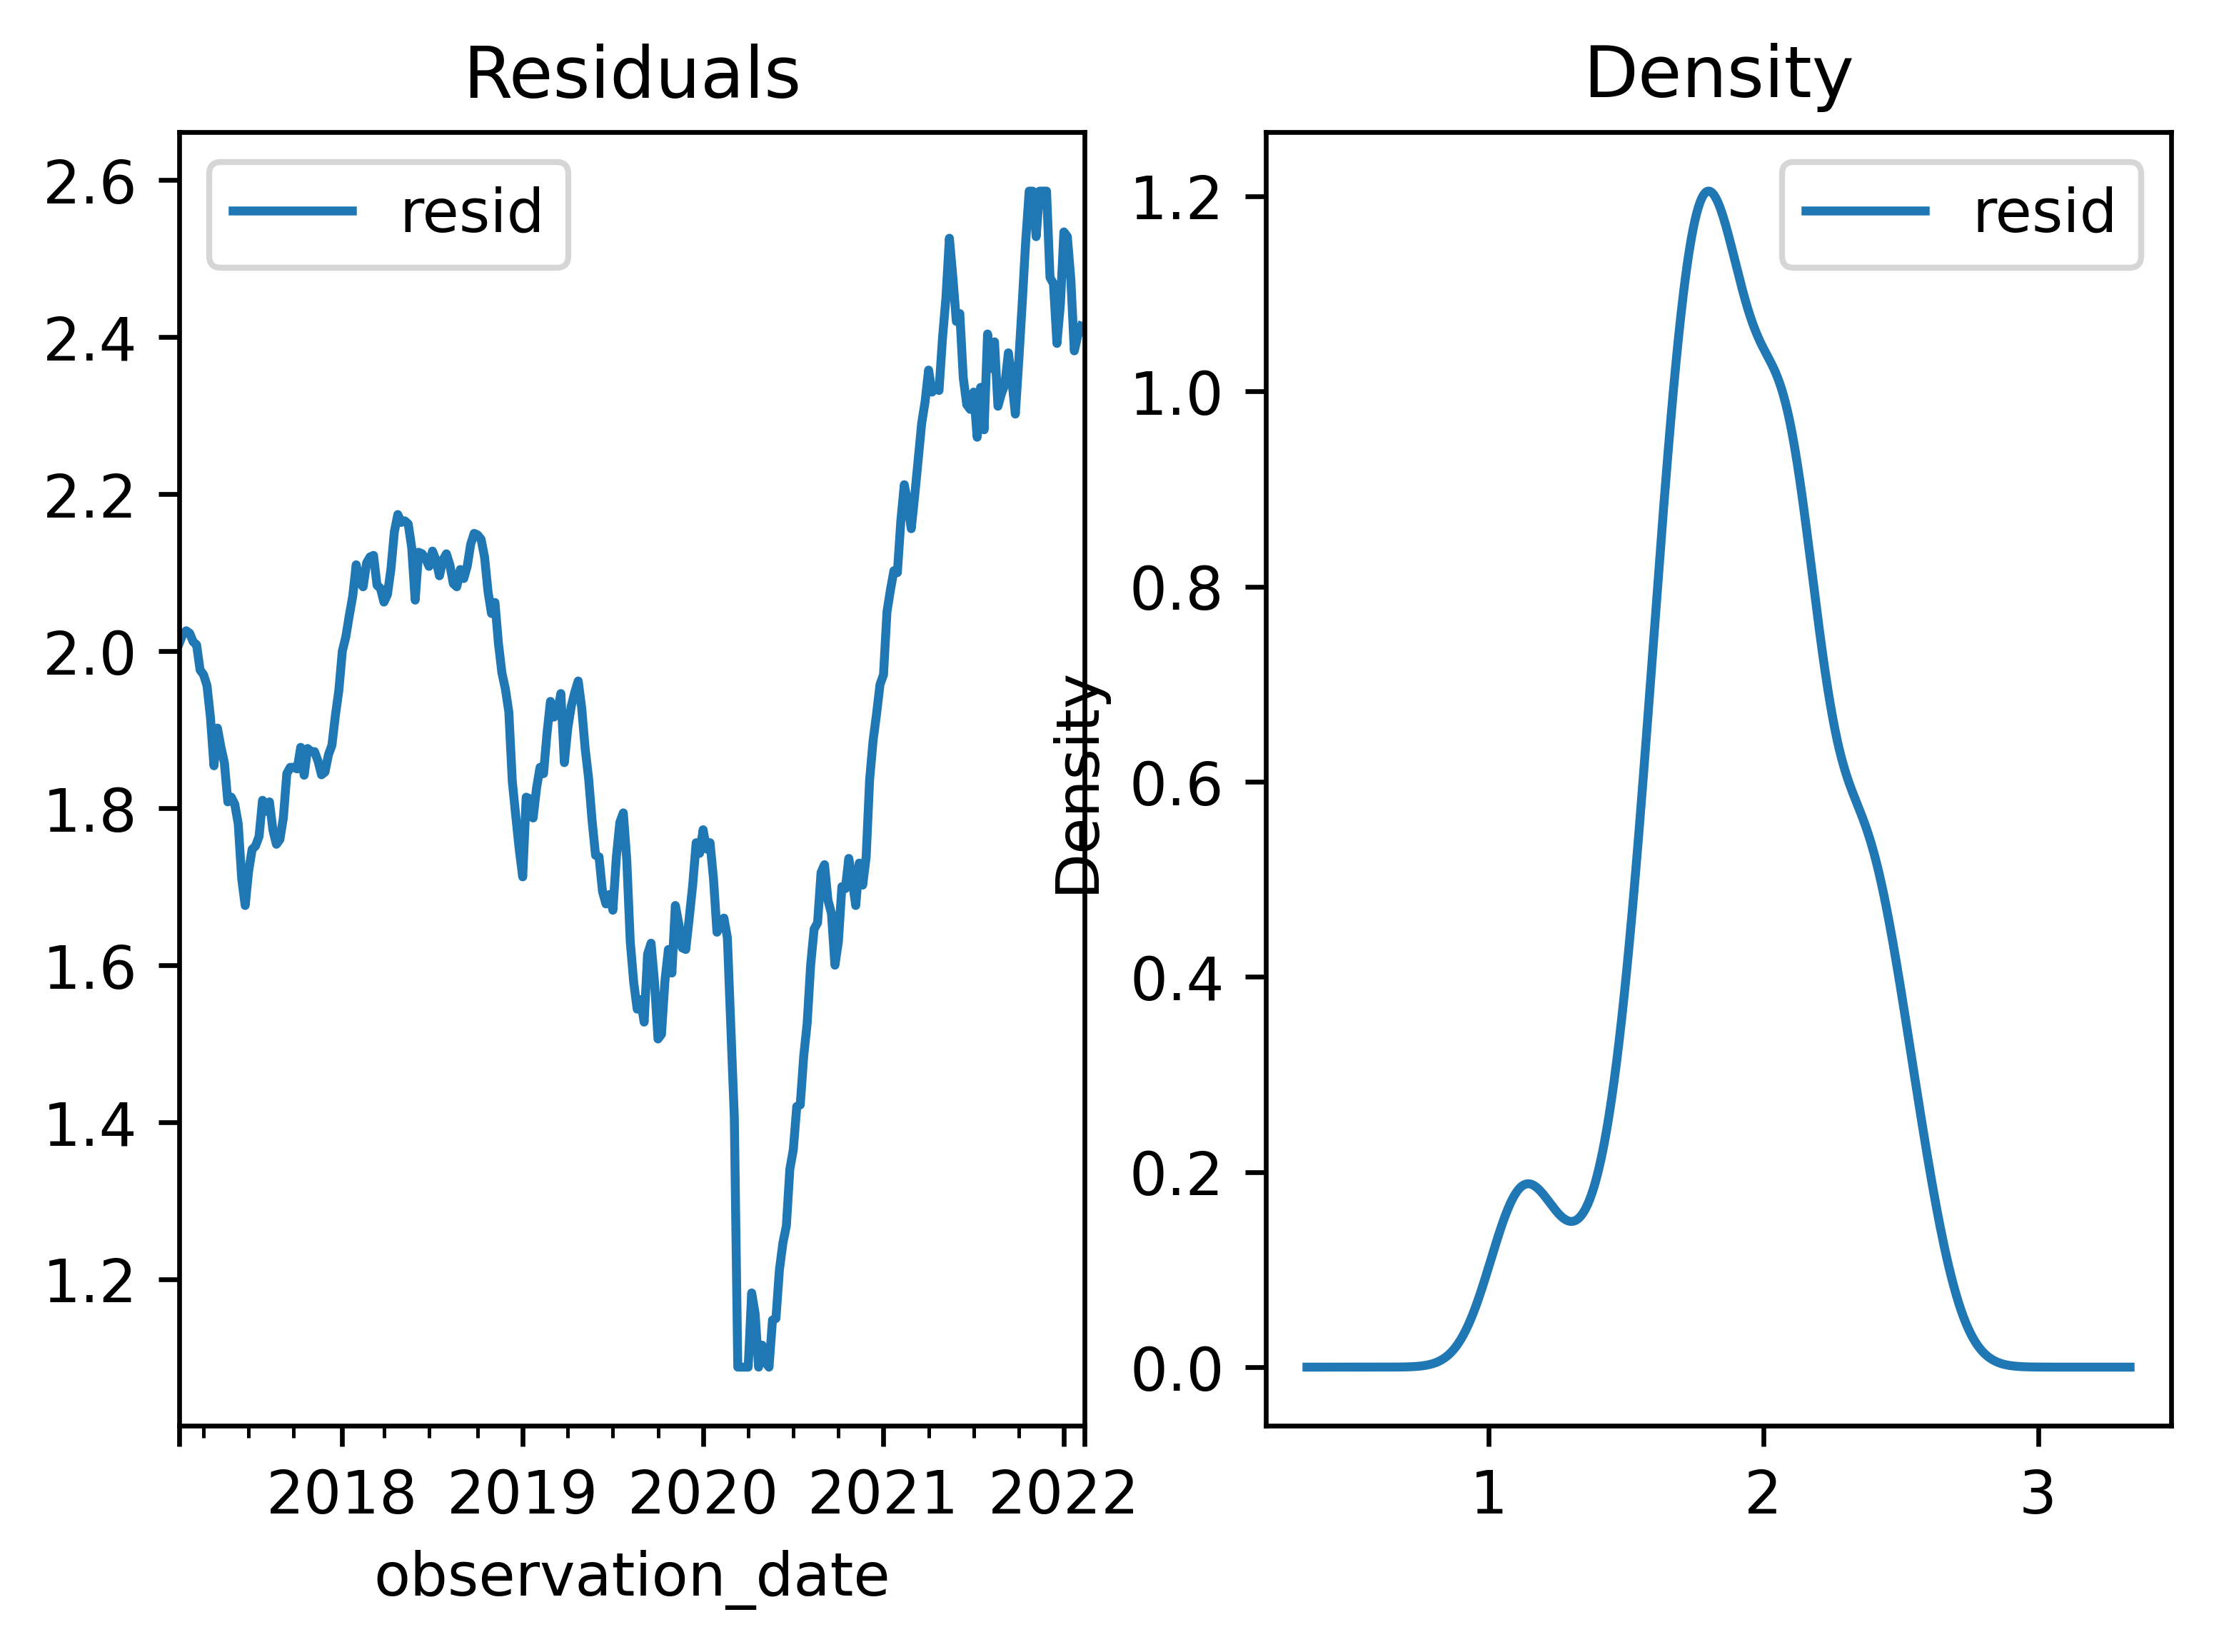

In [ ]:
residuals = pd.DataFrame(res.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

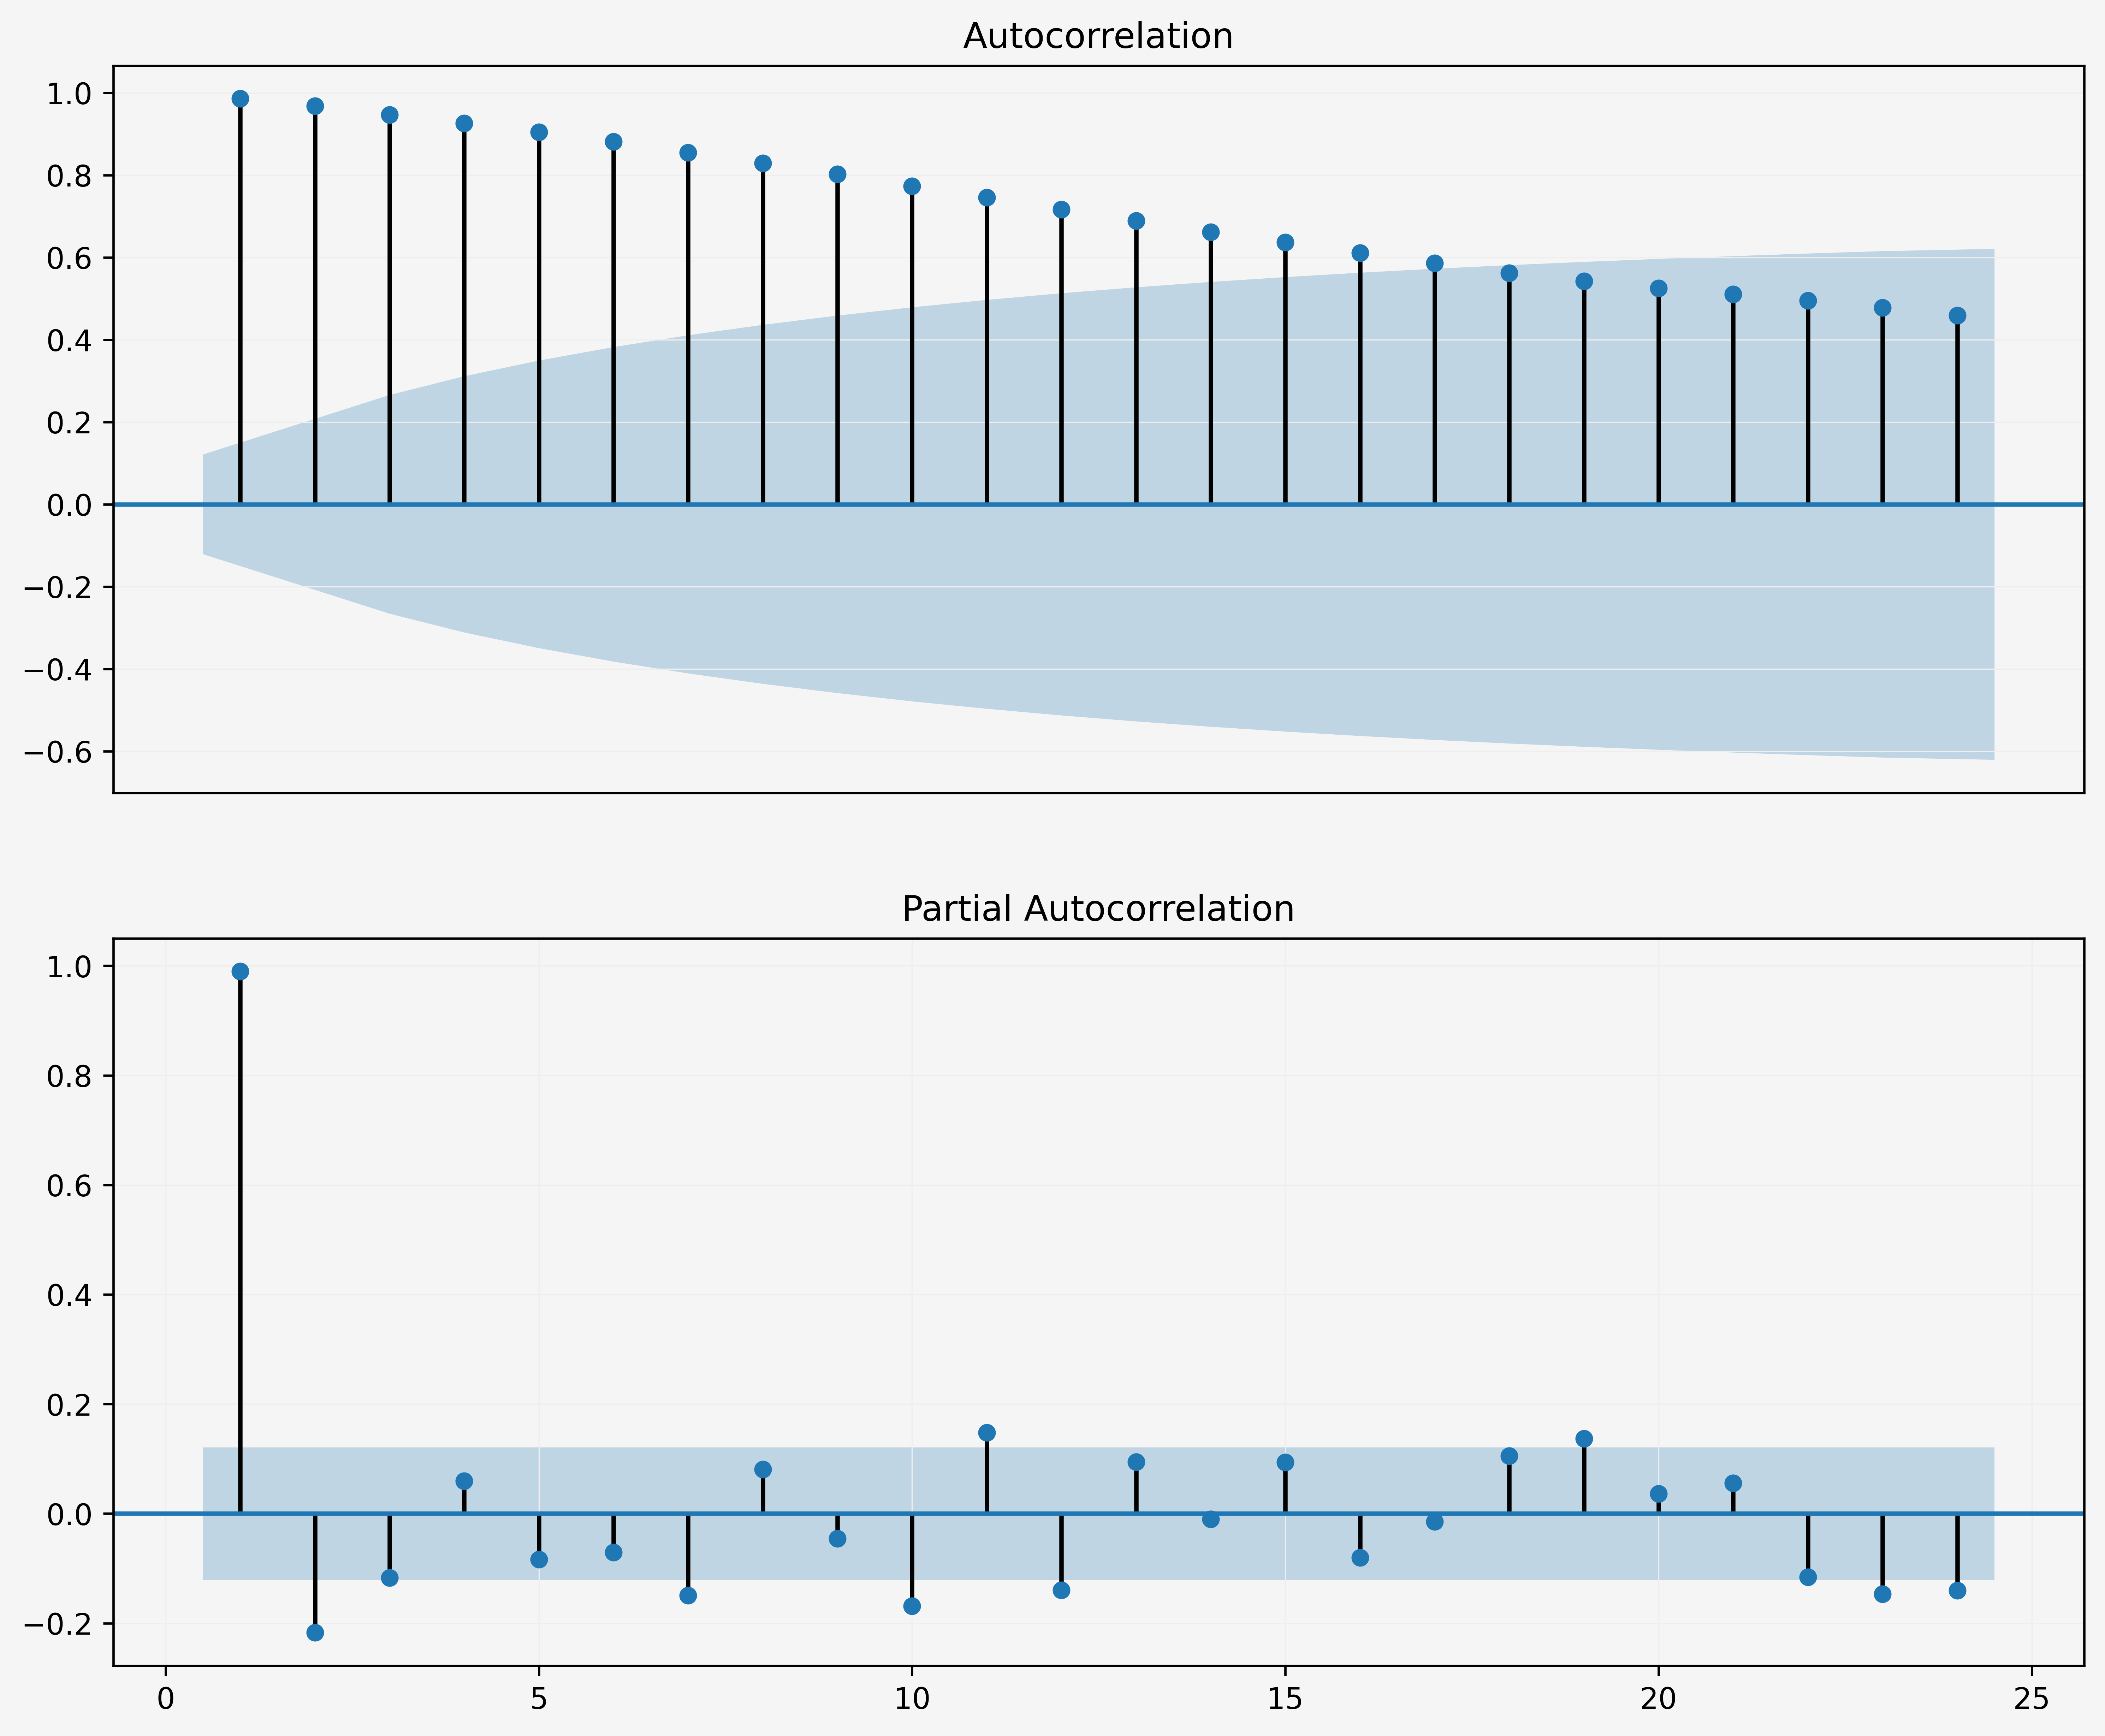

In [ ]:
make_autocorr_plot(residuals)

Построим прогноз ARCH(0,1,1)

In [ ]:
forecasts = res.forecast(reindex=False, method="simulation")

In [ ]:
print(forecasts.mean.iloc[-1:])
print(forecasts.residual_variance.iloc[-1:])
print(forecasts.variance.head())

                  h.1
observation_date     
2022-02-13        0.0
                     h.1
observation_date        
2022-02-13        3.8067
                     h.1
observation_date        
2022-02-06        3.8067
2022-02-13        3.8067


# Второй датасет

In [ ]:
df2 = pd.read_excel('./dataset_2.xlsx')
df2['TRADEDATE'] = pd.to_datetime(df2['TRADEDATE'])
df2 = df2.set_index('TRADEDATE')

In [ ]:
df2.head(5)

,RTS
TRADEDATE,
2022-01-01,1435.23
2021-12-01,1595.76
2021-11-01,1645.81
2021-10-01,1843.83
2021-09-01,1777.74


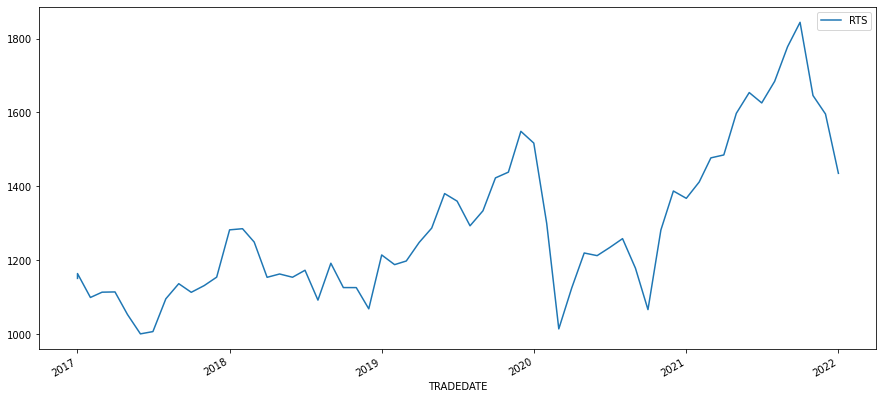

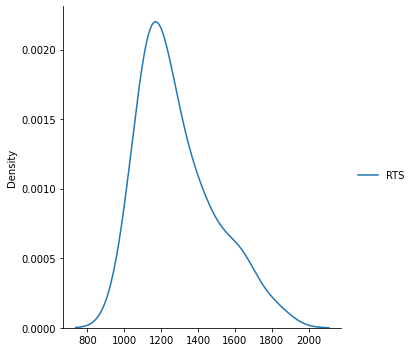

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


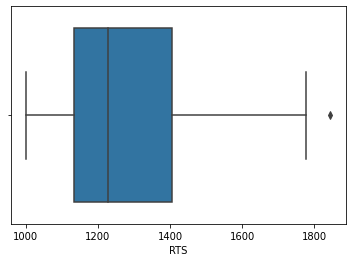

In [ ]:
graphs(df2)

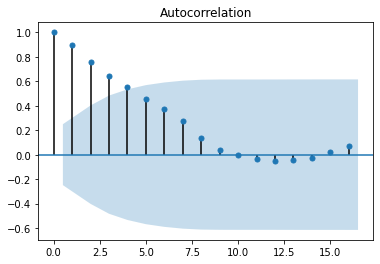

In [ ]:
plot_acf(df2['RTS'], lags = 16)
plt.show()

In [ ]:
IsStationary(df2['RTS'])

ADF Statistic: -2.287732
p-value: 0.175955
Critical Values:
	1%: -3.544
	5%: -2.911
	10%: -2.593
p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
excess kurtosis of normal distribution (should be 0): 0.02191131925222045
skewness of normal distribution (should be 0): 0.891259445862621
Тест Сиджела-Тьюки
z value: -1.309
Probably the same distribution
Тест Манна-Уитни
stat=120, p=120
Probably different distributions
